# Estatísticas experimentoqos

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Join entre Stress e Feedbacks

feedbacks = pd.read_csv("Feedbacks_1109 - feedbacks.csv", parse_dates=['created_date'])
stress = pd.read_csv("Feedbacks_1109 - stress.csv", parse_dates=['created_date'])

stress_sid = stress[pd.notna(stress['session_id'])] # pega os que tem session_id preenchido
stress_email = stress[pd.notna(stress['email'])] # pega os que tem email preenchido
stress_email = stress_email[ ~stress_email['session_id'].isin(stress_sid['session_id']) ] # pega os que tem email sem session_id
stress_final = pd.concat([stress_sid, stress_email])

feedbacks_stress = pd.merge(feedbacks, stress_final, on=['session_id', 'email'], how='inner')
feedbacks_stress.drop(columns = ['created_date_y', 'num_sessao_y'], inplace=True)
feedbacks_stress.rename(index=str, columns={'created_date_x':'created_date', 'num_sessao_x':'num_sessao', 'id_x':'id', 'justificativa_x':'justificativa'}, inplace=True)

feedbacks_stress = feedbacks_stress.loc[feedbacks_stress['num_video_preferido'] > 0]

In [3]:
#normaliza os dados da versao 1 para range de 5
def normalize_v1(feedbacks):
    feedbacks.loc[feedbacks['versao'] == 1, ['incomodo', 'interesse1', 'interesse2'] ] //= 2
    return feedbacks

feedbacks_stress = normalize_v1(feedbacks_stress)

In [4]:
# inversao dos valores das sessoes que tem o primeiro video com QoS alta

def swap_ints(feedbacks):
    feedbacks = feedbacks.reset_index(drop=True)

    for i in range(len(feedbacks.index)):
        if feedbacks.loc[i, 'created_date'].month < 7:
            if feedbacks.loc[i]['num_sessao'] in (1, 3, 6):
                feedbacks.at[i, 'interesse1'], feedbacks.at[i, 'interesse2'] = feedbacks.at[i, 'interesse2'], feedbacks.at[i, 'interesse1']
                if feedbacks.at[i, 'num_video_preferido'] == 1:
                    feedbacks.at[i, 'num_video_preferido'] = 2
                else:
                    feedbacks.at[i, 'num_video_preferido'] = 1                   
        else:

            if feedbacks.loc[i, 'num_sessao'] in (1, 5):
                feedbacks.at[i, 'interesse1'], feedbacks.at[i, 'interesse2'] = feedbacks.at[i, 'interesse2'], feedbacks.at[i, 'interesse1']

                if feedbacks.at[i, 'num_video_preferido'] == 1:
                    feedbacks.at[i, 'num_video_preferido'] = 2
                else:
                    feedbacks.at[i, 'num_video_preferido'] = 1
    return feedbacks

feedbacks_stress = swap_ints(feedbacks_stress)

In [6]:
#estatisticas basicas
feedbacks_stress['dif_interesses'] = (feedbacks_stress['interesse1'] - feedbacks_stress['interesse2'])
feedbacks_stress[['num_sessao', 'num_video_preferido', 'incomodo', 'interesse1', 'interesse2', 'dif_interesses', 'estresse']].describe()

# print(feedbacks_stress.loc[7, ['incomodo', 'interesse1', 'interesse2', 'num_video_preferido', 'justificativa']])

,num_sessao,num_video_preferido,incomodo,interesse1,interesse2,dif_interesses,estresse
count,505.000000,505.000000,505.00000,505.000000,505.000000,505.000000,505.000000
mean,4.073267,1.526733,3.70099,3.239604,2.710891,0.528713,7.150495
std,2.097944,0.499780,1.27074,1.394439,1.507778,1.596023,2.306204
min,1.000000,1.000000,0.00000,0.000000,0.000000,-5.000000,0.000000
25%,2.000000,1.000000,3.00000,2.000000,2.000000,0.000000,6.000000
50%,4.000000,2.000000,4.00000,4.000000,3.000000,0.000000,8.000000
75%,6.000000,2.000000,5.00000,4.000000,4.000000,2.000000,9.000000
max,7.000000,2.000000,5.00000,5.000000,5.000000,5.000000,10.000000


In [7]:
feeds_cor = feedbacks_stress[['interesse1', 'interesse2', 'incomodo', 'num_video_preferido']]
# pd.plotting.scatter_matrix(feeds_cor, figsize=(8, 8))
feeds_cor.corr()

,interesse1,interesse2,incomodo,num_video_preferido
interesse1,1.000000,0.397280,0.139048,-0.246936
interesse2,0.397280,1.000000,0.178473,0.326238
incomodo,0.139048,0.178473,1.000000,0.161009
num_video_preferido,-0.246936,0.326238,0.161009,1.000000


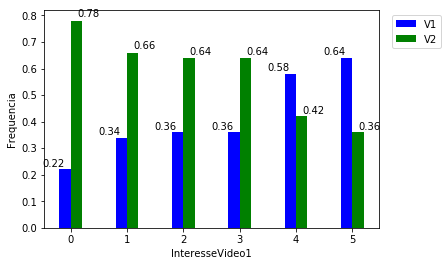

In [29]:
# grafico (interessev1 x preferencia/escolha usuario)

counts = feedbacks_stress.groupby(['interesse1','num_video_preferido'], as_index=False).size().unstack(fill_value=0).reset_index()
counts['V1_percent'] = round(counts[1]/(counts[1]+counts[2]), 2)
counts['V2_percent'] = round(counts[2]/(counts[1]+counts[2]), 2)

ax = plt.subplot()
b1 = ax.bar(counts['interesse1']-0.1, counts['V1_percent'],width=0.2,color='b',align='center')
b2 = ax.bar(counts['interesse1']+0.1, counts['V2_percent'],width=0.2,color='g',align='center')


leg = plt.legend((b1[0], b2[0]), ('V1', 'V2'), loc = 'upper right')

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 0.2
bb.x0 += xOffset
bb.x1 += xOffset

leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.ylabel('Frequencia')
plt.xlabel('InteresseVideo1')


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(b1, "left")
autolabel(b2, "right")
plt.show()

In [11]:
# teste pareado
from math import sqrt
dif_interesses = feedbacks_stress['dif_interesses']
n = len(dif_interesses)

mean = np.mean(dif_interesses)
std = np.std(dif_interesses)

std_amostral = std/sqrt(n)

T = mean/(std_amostral)
T

7.451726073719584